# CNN for Number Recognition 
Author: Tom Schubert

### Quellen:
1. https://nextjournal.com/gkoehler/pytorch-mnist
2. https://ravivaishnav20.medium.com/handwritten-digit-recognition-using-pytorch-get-99-5-accuracy-in-20-k-parameters-bcb0a2bdfa09
3. pytorch docs

In [1]:

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters

In [2]:
momentum = 0.9    # https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
epochs = 8           # Wie oft alle Images durch den Trainingsprozess laufen müssen
learning_rate = 0.01   # Linearer Faktor in Gradient Decent zum skaliern der Gradientenänderung
# Defines how many pictures are getting processed parallel (before backpropagation)
batch_size_train = 128   # batch size for Training
batch_size_test = 1000  # batch size for testing    https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

log_interval = 5

# for random functions generate seed
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download Dataset with specified Downloader

In [3]:
# MNIST data Set comes in PILLOW Images with (28,28) and Intensity between 0-255
# First gets downloaded
# Second gets converted to FloatTensor with values between 0-1
# Third gets Normalized with mean=0, stdev=1
# Output is a Dataloader which is an iterable --° enumerate for tensers

# If no transformation to a tensor is made the data can get read over the dataloader object 
'''
import numpy as np
print(train_loader.dataset[0][0])
x=np.array(train_loader.dataset[0][0])
print(x.shape)
'''

#https://pytorch.org/docs/stable/data.html
train_loader = torch.utils.data.DataLoader(
  # Download MNIST Dataset
    # location
    #for Training
    # Download if not already downloaded
    # Process Data:
      #Transform to Tensor
      # Normalize Data
  # batch size
  # Shuffle the training data to make it independent of the order
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                              # Transdormation Pipeline  https://pytorch.org/vision/stable/transforms.html
                             transform=torchvision.transforms.Compose([
                               # Scale Image from 0-255 to 0-1  https://discuss.pytorch.org/t/how-does-transforms-totensor-work-and-computation-of-mean-and-std-values/9085
                               torchvision.transforms.ToTensor(),
                               # the mean=0, stdev=1 scaling, (Normalizing)  https://www.youtube.com/watch?v=dXB-KQYkzNU&ab_channel=deeplizard
                               torchvision.transforms.Normalize(
                                 (0.13195264339447021,), (0.30903369188308716,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    # Download MNIST Dataset
    # location
    #for Testing
    # Download if not already downloaded
    # Process Data:
      #Transform to Tensor
      # Normalize Data
  # batch size
  # Shuffle the training data to make it independent of the order
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.13195264339447021,), (0.30903369188308716,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Print some examples from dataset (Training Part)

In [4]:
# iterate over the batches loaded by the loader
#TENSORS: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.htm
examples_train = enumerate(train_loader)
#print(train_loader.dataset[0])--> get first dataset
#next(examples_train)
# batch_idx gives index of batch
# train_data img data
# targets labels
batch_idx_training, (train_data, targets_training) = next(examples_train)
# Index des batches
print(batch_idx_training)
#torch.Size([64, 1, 28, 28])
# 64 Beispiele mit 28x28 Pixeln
print(train_data.shape)
print(targets_training)

# GET std and mean from dataset based on the tensor vector which already got scaled down to 0-1
#print(f"Mean: {train_data.data.float().mean()}") #on normal Dataset without normalize the value would be --> 0.13195264339447021
#print(f"Std: {train_data.data.float().std()}") #on normal Dataset without normalize the value would be --> 0.30903369188308716

# These Values are also taken for normalizing all data points --> (datapoint - mean) /std

# Print numpy array of data
nparray=np.array(train_data.data[0][0])
#print(nparray)
# GEt max value from array
from numpy.lib.index_tricks import unravel_index
x1,y1=unravel_index(nparray.argmax(), nparray.shape)
print(nparray[x1,y1])
# Plot data
#plt.imshow(nparray)

0
torch.Size([128, 1, 28, 28])
tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8, 7, 6, 4, 9, 1, 5, 3, 2, 6, 8, 8, 6, 9, 4,
        6, 0, 4, 2, 6, 7, 0, 5, 8, 6, 0, 3, 5, 7, 4, 7, 5, 1, 6, 7, 3, 6, 0, 3,
        1, 1, 2, 6, 7, 9, 8, 0, 7, 2, 4, 3, 6, 5, 9, 5, 2, 3, 5, 3, 5, 8, 9, 2,
        7, 1, 2, 4, 0, 2, 0, 6, 7, 2, 9, 5, 7, 1, 2, 2, 3, 3, 8, 8, 1, 0, 5, 7,
        5, 9, 6, 7, 2, 5, 9, 7, 5, 7, 1, 7, 8, 7, 8, 8, 8, 2, 1, 4, 1, 1, 3, 2,
        9, 5, 1, 9, 0, 3, 0, 3])
2.8089085


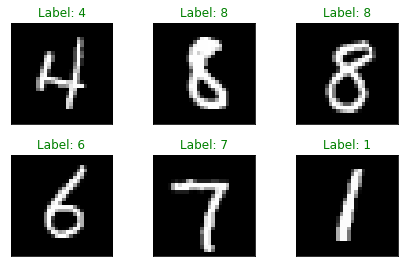

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray')
  plt.title("Label: {}".format(targets_training[i]),color='green')
  plt.xticks([])
  plt.yticks([])

# Print some examples from dataset (Test Part)

In [6]:
# iterate over the batches loaded by the loader
#TENSORS: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.htm
examples_test = enumerate(train_loader)
#next(examples_test)
batch_idx_test, (test_data, targets_test) = next(examples_test)
# Index des batches
print(batch_idx_test)
#torch.Size([64, 1, 28, 28])
# 64 Beispiele 1 Channel mit 28x28 Pixeln
print(train_data.shape)
print(targets_test)

0
torch.Size([128, 1, 28, 28])
tensor([9, 2, 9, 3, 0, 0, 2, 0, 5, 1, 9, 7, 4, 8, 8, 7, 5, 7, 2, 3, 1, 2, 7, 2,
        6, 8, 3, 3, 0, 8, 3, 1, 0, 7, 3, 0, 7, 7, 8, 5, 6, 7, 9, 7, 0, 0, 6, 7,
        3, 9, 5, 7, 1, 5, 7, 1, 4, 1, 8, 3, 8, 8, 0, 3, 9, 7, 5, 0, 2, 9, 1, 3,
        0, 3, 3, 8, 0, 7, 9, 8, 5, 2, 2, 5, 2, 3, 7, 4, 6, 4, 5, 6, 8, 6, 8, 9,
        3, 8, 8, 2, 9, 4, 3, 1, 8, 3, 4, 4, 9, 3, 6, 7, 5, 0, 8, 8, 1, 3, 8, 3,
        3, 6, 3, 4, 1, 4, 1, 9])


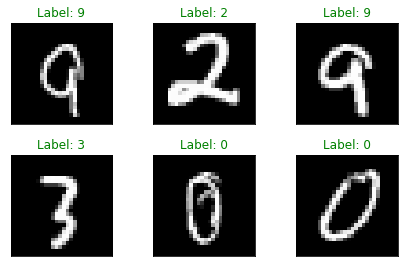

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(test_data[i][0], cmap='gray')
  plt.title("Label: {}".format(targets_test[i]),color='green')
  plt.xticks([])
  plt.yticks([])

# CNN

In [8]:
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from CNN import CNN

#           Definition of CNN-Modell
<center><img src="img/CNN_Architecture.png"/></center>


In [9]:
# CNN Klasse
cnn = CNN()
# Stochastic gradient descent
# USe  network.cuda() to transport params to gpu
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,momentum=momentum)

In [10]:
#summary(cnn, input_size=(1, 28, 28))

# Training Definition

In [11]:
# Store the losses calculated while training 
train_losses = []
# Store how many images got trained (make a list for plotting)
train_counter = []
# Store the losses calculated while testing 
test_losses = []
# Store how many images got testes (make a list for plotting)
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

In [12]:
def train(epoch, model, train_loader, optimizer):
  model.train()
  progress_bar=tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    # gradient auf 0 zurücksetzten
    optimizer.zero_grad()
    output = model(data)
    #The negative log likelihood loss.
    loss = F.nll_loss(output, target)
    # BAckpropagation
    loss.backward()
    # Performs a single optimization step.
    optimizer.step()
    # Log every log_interval
    if batch_idx % log_interval == 0:
      progress_bar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(train_loader.dataset),
      100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(train_loader.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

# Testing

In [13]:
def test(model,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  # Do not compute a gradient
  with torch.no_grad():
    for data, target in test_loader:
      # label data: Put the test dataset into the model and let it get labeled
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      # Get prediction from labeld data
      pred = output.data.max(1, keepdim=True)[1]
      # count how many were correct
      correct += pred.eq(target.data.view_as(pred)).sum()
  # log test_loss
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Test an empty untrained model

In [14]:
test(model=cnn,test_loader=test_loader)


Test set: Avg. loss: 2.3040, Accuracy: 980/10000 (10%)



# Train the model

In [15]:
for epoch in range(1, epochs + 1):
  train(epoch,cnn, train_loader, optimizer)
  test(cnn,test_loader)

100%|██████████| 469/469 [02:55<00:00,  2.67it/s]
Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.187539:   0%|          | 0/469 [02:55<?, ?it/s]



Test set: Avg. loss: 0.1378, Accuracy: 9605/10000 (96%)



100%|██████████| 469/469 [02:54<00:00,  2.69it/s]
Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.159172:   0%|          | 0/469 [02:54<?, ?it/s]



Test set: Avg. loss: 0.0715, Accuracy: 9783/10000 (98%)



100%|██████████| 469/469 [02:48<00:00,  2.79it/s]
Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.057393:   0%|          | 0/469 [02:48<?, ?it/s]



Test set: Avg. loss: 0.0483, Accuracy: 9863/10000 (99%)



100%|██████████| 469/469 [02:53<00:00,  2.71it/s]
Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.082413:   0%|          | 0/469 [02:53<?, ?it/s]



Test set: Avg. loss: 0.0382, Accuracy: 9885/10000 (99%)



100%|██████████| 469/469 [02:52<00:00,  2.72it/s]
Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.050822:   0%|          | 0/469 [02:52<?, ?it/s]



Test set: Avg. loss: 0.0383, Accuracy: 9885/10000 (99%)



100%|██████████| 469/469 [02:54<00:00,  2.69it/s]
Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.099834:   0%|          | 0/469 [02:54<?, ?it/s]



Test set: Avg. loss: 0.0326, Accuracy: 9899/10000 (99%)



100%|██████████| 469/469 [03:02<00:00,  2.57it/s]
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.040009:   0%|          | 0/469 [03:02<?, ?it/s]



Test set: Avg. loss: 0.0309, Accuracy: 9910/10000 (99%)



100%|██████████| 469/469 [02:48<00:00,  2.79it/s]
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.036155:   0%|          | 0/469 [02:48<?, ?it/s]



Test set: Avg. loss: 0.0251, Accuracy: 9924/10000 (99%)



# Performance

752
752


Text(0, 0.5, 'negative log likelihood loss')

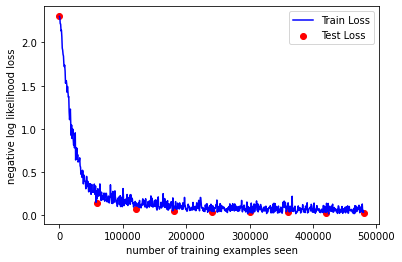

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
print(len(train_counter))
print(len(train_losses))
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Test the model and make some Predictions

In [17]:
def test_model(model,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  # Do not compute a gradient
  with torch.no_grad():
    for data, target in test_loader:
      # label data: Put the test dataset into the model and let it get labeled
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      # Get prediction from labeld data
      pred = output.data.max(1, keepdim=True)[1]
      # count how many were correct
      correct += pred.eq(target.data.view_as(pred)).sum()
  # log test_loss
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [18]:
test_model(model=cnn,test_loader=test_loader)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32

Test set: Avg. loss: 251.2332, Accuracy: 9924/10000 (99%)



In [19]:
# Label the test_data set 
with torch.no_grad():
  output = cnn(test_data)

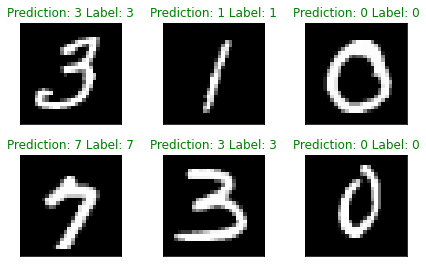

In [22]:
# plot some predictions from the test dataset
# First 6 predictions from actual example_test iteration step
fig = plt.figure()
k=30
#print(test_data[4+k][0].numpy()) # Get numpy array for data
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(test_data[i+k][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {} Label: {}".format(
    output.data.max(1, keepdim=True)[1][i+k].item(),targets_test[i+k]),color="green")
  plt.xticks([])
  plt.yticks([])


# Save the Model

In [21]:
#torch.save(cnn, './data/model.pth')
torch.save(cnn.state_dict(), './data/model.pth')